In [1]:
import os, glob, re, random, gzip, pysam, pyBigWig
import json
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib_venn import *
import seaborn as sns
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

# Benchmark of SNVs for duplicates flag +/-

In [2]:
sources = ["NanoSSCell", "NanoSSCell_RmDupFlag"]
repeats = [1, 2]
covs = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]

data = dict()
for s in sources:
    for r in repeats:
        for c in covs:
            path = "../../6_SNV_SV_Comparison/results/snvs/benchmark/nanocaller/%s.cov%d-r%d.txt" % (s, c, r)
            d = pd.read_csv(path, sep="\t")
            data[(s, c, r)] = d

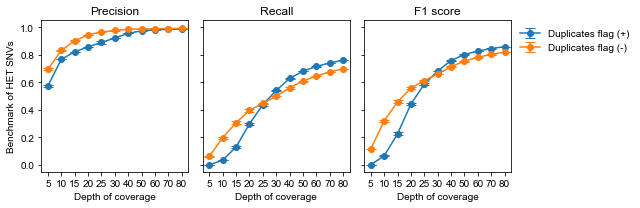

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

xs = np.arange(len(covs))
xticks = list(map(str, covs))

for i, name in enumerate(["Precision", "Recall", "F1"]):
    plt.sca(axs[i])
    title = name
    if name == "F1":
        title = "F1 score"
    plt.title(title)
    for s in sources:
        rows = []
        for c in covs:
            row = []
            for r in repeats:
                d = data[(s, c, r)]
                v = d[name].values[0]
                row.append(v)
            rows.append(row)
        d = pd.DataFrame(rows)
        d.index = covs
        d.columns = repeats
        ys = d.mean(axis=1)
        yerr = d.std(axis=1)
        label = s
        if s == "NanoSSCell":
            label = "Duplicates flag (+)"
        else:
            label = "Duplicates flag (-)"
        plt.errorbar(xs, ys, yerr=yerr, capsize=5, label=label, marker="o")
    plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Depth of coverage")
    if i == 0:
        plt.ylabel("Benchmark of HET SNVs")
    plt.xticks(xs, xticks)
    if i == 2:
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.savefig("figures/benchmark_het_snv.duplicate_flag.pdf", dpi=300)

# Benchmark SNVs for NanoStrand-seq, ONT-UL and PB-CCS

## 1. Benchmark of SNP for full depth

In [2]:
sources = ["PacBio.full", "Ultralong.full", "NSS.full"]

rows = []
for i, s in enumerate(sources):
    path = "../../nss-pseudobulk-analysis/results/snvs/benchmark/nanocaller/%s.json" % s
    data = json.load(open(path))
    r = data["Het_SNP_Recall"]
    p = data["Het_SNP_Precision"]
    f = data["Het_SNP_F1"]
    rows.append([r, p, f])
d = pd.DataFrame(rows, columns = ["Recall", "Precision", "F1"], index=sources)
d

,Recall,Precision,F1
PacBio.full,0.993303,0.997929,0.995611
Ultralong.full,0.912280,0.961036,0.936023
NSS.full,0.795579,0.989981,0.882197


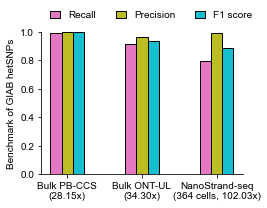

In [4]:
ticks = ["Bulk PB-CCS\n(28.15x)", "Bulk ONT-UL\n(34.30x)", "NanoStrand-seq\n(364 cells, 102.03x)"]
legends = ["Recall", "Precision", "F1 score"]
colors = ["C6", "C8", "C9"]

xs = np.arange(3)

plt.figure(figsize=(3.8, 3))

w = 0.15

for i in range(3):
    ys = np.array(d[d.columns[i]].values)
    plt.bar(xs + i * w - w, ys, width=w, edgecolor="black", label=legends[i], color=colors[i], clip_on=True)

plt.ylabel("Benchmark of GIAB hetSNPs")
plt.xticks(xs, ticks, rotation=0)
ax = plt.gca().spines["top"].set_visible(False)
ax = plt.gca().spines["right"].set_visible(False)
plt.ylim(0, 1)
plt.legend(loc="lower left", bbox_to_anchor=(0, 1.02), ncol=3, handlelength=1, frameon=False)
plt.tight_layout()
plt.savefig("figures/benchmark_het_snv.full.pdf", dpi=300)

## 2. Benchmark of SNP for downsample depth

In [19]:
queries = ["PacBio", "Ultralong", "NSS"]
covs = [10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = [1, 2]
colors = ["C0", "C1", "C3"]

rows = []
for que in queries:
    for cov in covs:
        for r in repeats:
            path = "../../nss-pseudobulk-analysis/results/snvs/benchmark/nanocaller/%s.cov%d-r%s.json" % (que, cov, r)
            if os.path.exists(path):
                d = json.load(open(path))
                recall, precision, f1 = d["Het_SNP_Recall"], d["Het_SNP_Precision"], d["Het_SNP_F1"]
                rows.append([que, cov, r, recall, precision, f1])
df = pd.DataFrame(rows)
df.columns = ["Query", "Depth", "Repeat", "Recall", "Precision", "F1"]
df.head()

,Query,Depth,Repeat,Recall,Precision,F1
0,PacBio,10,1,0.766038,0.997420,0.866549
1,PacBio,10,2,0.766954,0.997172,0.867041
2,PacBio,15,1,0.952197,0.997779,0.974455
3,PacBio,15,2,0.952409,0.997743,0.974549
4,PacBio,20,1,0.982536,0.997919,0.990168


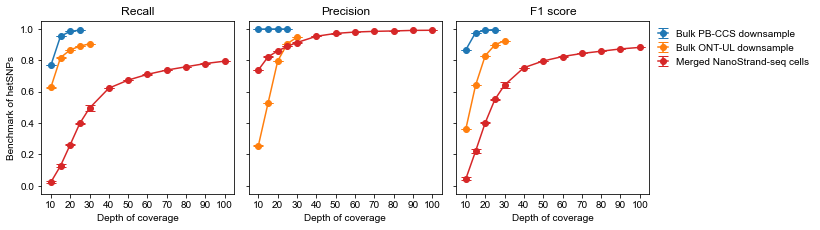

In [28]:
labels = ["Bulk PB-CCS downsample", "Bulk ONT-UL downsample", "Merged NanoStrand-seq cells"]
fig, axs = plt.subplots(1, 3, figsize=(11.5, 3.3), sharex=True, sharey=True)

for i in range(3):
    plt.sca(axs[i])
    
    if i == 0:
        column = "Recall"
    elif i == 1:
        column = "Precision"
    else:
        column = "F1"
        
    for j, que in enumerate(queries):
        d = df[df["Query"] == que]
        m1 = d["Depth"].values.reshape((-1, 2))
        m2 = d[column].values.reshape((-1, 2))
        xs = m1[:,0]
        means = np.mean(m2, axis=1)
        stds = np.std(m2, axis=1)
        plt.errorbar(xs, means, yerr=stds, capsize=5, color=colors[j], label=labels[j], marker="o")
        
    plt.xlim(5, 105)
    plt.xticks(np.arange(10, 105, 10))
    plt.xlabel("Depth of coverage")
    if i == 0:
        plt.title("Recall")
        plt.ylabel("Benchmark of hetSNPs")
    elif i == 1:
        plt.title("Precision") 
    elif i == 2:
        plt.title("F1 score")
    plt.ylim(-0.05, 1.05)
    if i == 2:
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, handlelength=1)

plt.tight_layout()
plt.savefig("figures/benchmark_het_snv.downsample.pdf", dpi=300)

# Compare 4 VCFs

GIAB, PB-CCS, ONT-UL, NSS

In [16]:
def load_snps(vcf, bed, chroms):
    print("Loading:", vcf)
    
    regions = list(sorted(BedFile(bed)))
    loader = ShiftLoader(regions)
    print("Regions:", len(regions))
    
    snps = []
    with pysam.VariantFile(vcf) as f:
        sample = list(f.header.samples)[0]
        for chrom in sorted(chroms):
            for record in f.fetch(chrom):
                gt = record.samples[sample]["GT"]
                b1, b2 = record.alleles[gt[0]], record.alleles[gt[1]]
                if b1 == b2:
                    continue
                if len(b1) > 1 or len(b2) > 1:
                    continue
                snp = GRange(chrom, record.start, record.stop)
                if b1 > b2:
                    b1, b2 = b2, b1
                snp.alleles = [b1, b2]
                snps.append(snp)
    print("Het SNPs:", len(snps))
    
    snps1 = []
    for snp in sorted(snps):
        if len(list(loader.fetch(obj=snp))) > 0:
            snps1.append(snp)
    print("Filtered het SNPs:", len(snps1))
    
    return snps1


vcfs = [
    "../../GRCh38-HG001-Variant-Calls/results/benchmark_autosomal_v4.2.1_chrx_v3.3.2.vcf.gz",
    "../../nss-pseudobulk-analysis/results/snvs/concated/nanocaller/PacBio.full.vcf.gz",
    "../../nss-pseudobulk-analysis/results/snvs/concated/nanocaller/Ultralong.full.vcf.gz",
    "../../nss-pseudobulk-analysis/results/snvs/concated/nanocaller/NSS.full.vcf.gz"
]

bed = "../../GRCh38-HG001-Variant-Calls/results/benchmark_autosomal_v4.2.1_chrx_v3.3.2.bed.gz"

chroms = list(sorted(["chr%d" % i for i in range(1, 23)]))

snps_list = [load_snps(vcf, bed, chroms) for vcf in vcfs]

Loading: ../../GRCh38-HG001-Variant-Calls/results/benchmark_autosomal_v4.2.1_chrx_v3.3.2.vcf.gz
Regions: 666945
Het SNPs: 2028439
Filtered het SNPs: 1966578
Loading: ../../nss-pseudobulk-analysis/results/snvs/concated/nanocaller/PacBio.full.vcf.gz
Regions: 666945
Het SNPs: 2414137
Filtered het SNPs: 1957471
Loading: ../../nss-pseudobulk-analysis/results/snvs/concated/nanocaller/Ultralong.full.vcf.gz
Regions: 666945
Het SNPs: 2247806
Filtered het SNPs: 1866818
Loading: ../../nss-pseudobulk-analysis/results/snvs/concated/nanocaller/NSS.full.vcf.gz
Regions: 666945
Het SNPs: 1854680
Filtered het SNPs: 1580408


In [17]:
keys_list = [set([(snp.chrom, snp.start, snp.alleles[0], snp.alleles[1]) for snp in snps]) for snps in snps_list]
keys1, keys2, keys3, keys4 = keys_list

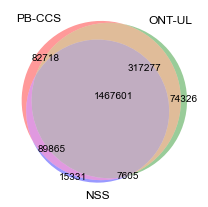

In [18]:
plt.figure(figsize=(3, 3))
venn3([keys2, keys3, keys4], set_labels=["PB-CCS", "ONT-UL", "NSS"])
plt.tight_layout()
plt.show()

In [19]:
all_keys = keys1 | keys2 | keys3 | keys4

In [20]:
counter = defaultdict(int)
for key in all_keys:
    flags = tuple([key in keys for keys in keys_list])
    counter[flags] += 1

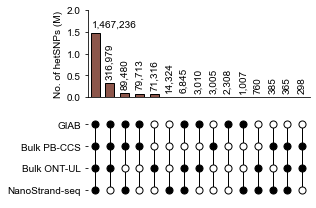

In [27]:
items = list(sorted(counter.items(), key=lambda item: item[1], reverse=True))
xs = np.arange(len(items))
counts = [item[1] for item in items]
ys = [c / 1e6 for c in counts]

fig, axs = plt.subplots(2, 1, figsize=(4.5, 3), sharex=True)

plt.sca(axs[0])
plt.bar(xs, ys, width=0.6,color="C5", edgecolor="black")
for x, y, count in zip(xs, ys, counts):
    if x == 0:
        plt.text(x - 0.2, y + 0.1, format(count, ","), rotation=0, ha="left", va="bottom")
    else:
        plt.text(x, y + 0.1, format(count, ","), rotation=90, ha="center", va="bottom")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 2)
plt.ylabel("No. of hetSNPs (M)")
if True:
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
plt.sca(axs[1])
for x in xs:
    plt.plot([x, x], [0, 3], lw=1, color="black")
    ys = []
    for y, flag in enumerate(items[x][0]):
        ys.append(y)
        color = "black" if flag else "white"
        plt.scatter(x, y, color=color, edgecolor="black", s=50, zorder=10)
    
plt.ylim(3.5, -0.5)
plt.yticks(ys, ["GIAB", "Bulk PB-CCS", "Bulk ONT-UL", "NanoStrand-seq"])
plt.xticks([])
# plt.yticks([])
if True:
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)

plt.tight_layout()
plt.savefig("figures/Benchmark_of_hetSNPs.GIAB_PB_ONT_NSS.upset.pdf", dpi=300)